In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 100
import torch
from torch import nn
import zuko
from zuko.distributions import DiagNormal
from zuko.flows import FlowModule, MaskedAutoregressiveTransform, Unconditional
from zuko.transforms import SoftclipTransform
import numpy as np
from chainconsumer import ChainConsumer
from tqdm import tqdm
import corner
mpl.rcParams["figure.dpi"] = 150

from bayesian_gradabm.autoregressive_model import run_autoregressive_model, fit_autoregressive_model_pyro
from bayesian_gradabm.conditioner_encoders import RNN
from bayesian_gradabm.plotting import plot_flow_posterior

#torch.autograd.set_detect_anomaly(True)

In [81]:
# Parameters
n_timesteps = 50
true_parameters = torch.tensor([0.5])
sigma_noise = 0.1
encoding_size = 16
device = "cpu"

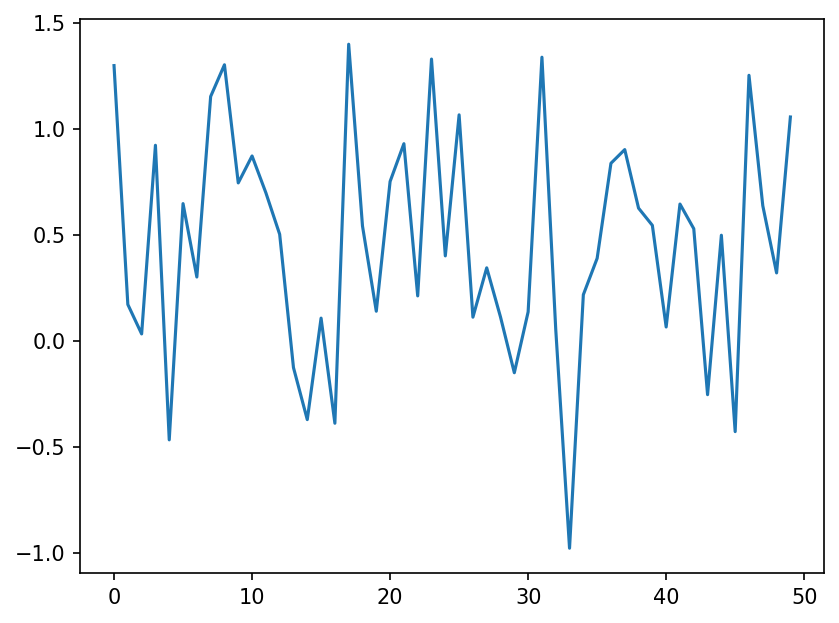

In [4]:
# Observed data
x_obs = run_autoregressive_model(true_parameters.reshape(1,1,-1), 
                                 n_timesteps=n_timesteps, 
                                 sigma_noise=sigma_noise)
plt.plot(x_obs.flatten().numpy())


In [82]:
# RNN to encode conditioning data
conditioner_rnn = RNN(input_size=1, hidden_size=64, num_layers=2, output_size=encoding_size, 
                      n_timesteps=n_timesteps)

In [41]:
# Define flow
flow = zuko.flows.MAF(len(true_parameters), encoding_size, transforms=5, hidden_features=[50])
flow = flow.to(device)

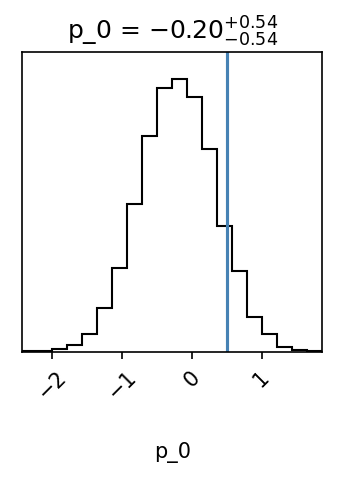

In [44]:
# plot initial posterior for observation
plot_flow_posterior(flow, conditioner_rnn(x_obs[0]), true_parameters)

In [124]:
def summarise_ar1(x):
    
    """
    x has dims (batch_size, T, dim_of_time_series = 1)    
    """
    
    x = x[:, :, 0]
#     mean = x.mean(dim=1).reshape(-1, 1)
    # MLE of theta1 with theta0 = 0 
    theta1_mle = ((x[:, 1:] * x[:, :-1]).sum(dim=1) / (x**2).sum(dim=1)).reshape(-1, 1)
    # lag-2 correlation
    l2corr = ((x[:, 2:] * x[:, :-2]).sum(dim=1)).reshape(-1, 1)
    return torch.cat((theta1_mle, l2corr), dim=-1)

In [6]:
def clip_samples(samples):
    samples_phi1 = torch.clip(samples[:,:,0].flatten(), -1.0, 1.0)
    #samples_phi2 = torch.clip(samples[:,:,-1].flatten(), min=None, max=torch.min(1-samples_phi1, 1 + samples_phi1))
    #samples = torch.vstack((samples_phi1, samples_phi2)).transpose(0,1)
    samples = samples_phi1.reshape((1, samples.shape[0], samples.shape[1]))
    return samples

In [130]:
def get_forecast_score(flow, x_cond, n_samples=5, summarise_cond=True):
    
    """
    x_cond has shape (batch_size, T, dim_of_time_series)
    """
    
    if summarise_cond:
        x_enc = summarise_ar1(x_cond)
    else:
        x_enc = conditioner_rnn(x_cond)
    samples = flow(x_enc).rsample((n_samples,))
#     samples = clip_samples(samples)
    samples = torch.clamp(samples, -1, 1)
    samples = torch.cat((torch.zeros((n_samples,x_cond.shape[0],1)), samples))
    samples = samples.reshape(x_cond.shape[0], n_samples, -1)
    xs = run_autoregressive_model(samples, n_timesteps=n_timesteps, sigma_noise=sigma_noise)
    x_cond_m = x_cond.unsqueeze(0).transpose(1,0)
    sqdiff = (x_cond_m - xs)**2
    sum_sqdiff = torch.sum(sqdiff)
    loss = sum_sqdiff / (x_cond.shape[0] * x_cond.shape[1] * n_samples)   #loss_fn(x_cond_m, xs) / n_samples
    return loss

In [125]:
def get_regularisation(flow, x_cond, n_samples=5, summarise_cond=True):
    
    """
    This is currently written specifically for zero-mean AR(1) process since it clips the lag-1 coefficient
    to range -1 to 1. Need to figure out how to deal with leakage outside prior, although this will matter less
    if we don't use KL divergence and instead use e.g. MMD.
    """
    
    # Assumes regularisation term is KL divergence between flow and prior
    # TODO: implement other divergences e.g. MMD
    # ALSO TODO: figure out how to get samples within bound of bounded prior
    
    # For each x: sample from the flow n_samples times; compute empirical mean of log of flow; subtract empirical
    # mean of log of prior
    if summarise_cond:
        x_enc = summarise_ar1(x_cond)
    else:
        x_enc = conditioner_rnn(x_cond)
    # Below is shape (n_samples, x_cond.shape[0], dim(theta))
    samples = flow(x_enc).rsample((n_samples,))
    # HARD-CODED FOR AR(1)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    samples = torch.clamp(samples, -1, 1)
    samples = torch.cat((torch.zeros((n_samples,x_cond.shape[0],1)), samples))
    # Empirical mean of log of flow
    log_flow = 0.
    for j in range(x_enc.shape[0]):
        log_flow += flow(x_enc[j]).log_prob(samples[:,j,:]).sum()
    log_flow /= (n_samples * x_enc.shape[0])
    # Empirical mean of log of prior – uniform, so just constant/no contribution since we assume all
    # flow samples are within prior support, even if only thanks to the clipping
    log_prior = 0.
    return log_flow - log_prior

In [22]:
def sample_prior(shape):
    phi_1_prior = torch.distributions.Uniform(-1.0 * torch.ones(shape), torch.ones(shape))
    phi_1 = phi_1_prior.sample()
    #phi_2_prior = torch.distributions.Uniform(-1.0 * torch.ones(shape), torch.min(1-phi_1, 1+phi_1))
    #phi_2 = phi_2_prior.sample()
    #phi = torch.hstack((phi_1, phi_2))
    phi = phi_1
    return phi

The loss we're going to use is drawn from the literature on variational inference/autoencoders and entails minimising a loss function of the form

\begin{equation}
    \mathbb{E}_{(\theta, x) \sim q_{\phi}(\theta \mid x) p(x)}\left[\log \frac{q_{\phi}(\theta \mid x)}{\pi(\theta)} \right] + \mathbb{E}_{(\theta, x) \sim q_{\phi}(\theta \mid x) p(x)}\left[\ell(x, \theta)\right]
\end{equation}

with respect to the flow parameters $\phi$, where $\ell(x, \theta)$ is some forecast scoring rule measuring the discrepancy between the real data $x$ and simulations generated at $\theta$. 

This covers both cases i.e. where we have one single sample from the real world or when we have multiple examples. $p(x)$ is the density according to which the real data is distributed, and if we have a single observed time series from the real world then $p(x)$ will just be a Dirac delta at that $x$.

The above loss can be seen as the average reconstruction error on the right and a regularisation term on the left.

To do:
- Implement loss above
- Simulate and save "observed" data from model 
- Code up true likelihood function for AR(p)
- Get ground-truth posterior samples for "observed" data

In [126]:
# Simulate "observed" time series

# We'll create 0-mean stationary AR(1) processes manually: 
thetas = torch.tensor([[[0., 0.1]],
                       [[0., -.3]],
                       [[0., -.6]],
                       [[0., 0.3]]])

xs = run_autoregressive_model(thetas, 
                              n_timesteps=n_timesteps, 
                              sigma_noise=sigma_noise)[:,0,...]

In [173]:
# RNN to encode conditioning data
encoding_size = 2
conditioner_rnn = RNN(input_size=1, hidden_size=64, num_layers=2, output_size=encoding_size, 
                      n_timesteps=n_timesteps)
# Define flow

class OffsetSigmoid(nn.Module):
    
    def __init__(self, lower=0., upper=1.):
        
        super().__init__()
        self.l = lower
        self.u = upper
        self.sig = nn.Sigmoid()
        
    def forward(self, x, **kwargs):
        
#         print(x, y)
#         print("forward")
        out = self.l + self.sig(x) * (self.u - self.l)
        return out
    
    def inv(self, x, **kwargs):
        
        return torch.logit((x - self.l) / (self.u - self.l))

class Clipped1D_MAF(FlowModule):

    def __init__(
        self,
        features: int,
        context: int = 0,
        transforms: int = 3,
        randperm: bool = False,
        upper: float = 1.,
        lower: float = 0.,
        **kwargs,
    ):
        orders = [
            torch.arange(features),
            torch.flipud(torch.arange(features)),
        ]

        transforms = [
            MaskedAutoregressiveTransform(
                features=features,
                context=context,
                order=torch.randperm(features) if randperm else orders[i % 2],
                **kwargs,
            )
            for i in range(transforms)
        ]

        base = Unconditional(
            DiagNormal,
            torch.zeros(features),
            torch.ones(features),
            buffer=True,
        )
        
        transforms.append(OffsetSigmoid(lower=lower, upper=upper))

        super().__init__(transforms, base)

dim_theta = 1
# flow = zuko.flows.MAF(dim_theta, encoding_size, transforms=5, hidden_features=[50])
flow = Clipped1D_MAF(dim_theta, encoding_size, transforms=5, hidden_features=[50], lower=-1., upper=1.)
flow = flow.to(device)

In [174]:
# Train model

parameters_to_optimize = list(flow.parameters()) + list(conditioner_rnn.parameters())
print(sum(p.numel() for p in parameters_to_optimize if p.requires_grad))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=1e-4)

n_batches = 1000
n_samples_per_batch = 50
n_samples_per_x_cond = 25

best_loss = np.inf
loss_hist = []
loss_hist_train = []

x_cond = xs[:2]
val_xs = xs[2:]

w = 0.

iterator = tqdm(range(n_batches))

for it in iterator:
    
    optimizer.zero_grad()
    # Simulating an AR(1) model
    ## params = sample_prior((n_samples_per_batch,1,)).reshape((1, n_samples_per_batch, -1))
    ## x_cond = run_autoregressive_model(parameters=params, n_timesteps=n_timesteps, sigma_noise=sigma_noise)[:,0,...]
    
    # This is the forecast/reconstruction score
    forecast_loss = get_forecast_score(flow=flow, x_cond=x_cond, n_samples=n_samples_per_x_cond)
    reglrise_loss = get_regularisation(flow=flow, x_cond=x_cond, n_samples=n_samples_per_x_cond)
    loss = forecast_loss + w*reglrise_loss
    if torch.isnan(loss):
        break
        
    loss.backward()
    loss_hist_train.append(loss.item())
    optimizer.step()
    
    with torch.no_grad():
        #params = sample_prior((n_samples_per_batch,1,)).reshape((1, n_samples_per_batch, -1))
        #params = clip_samples(params).reshape(n_samples_per_batch, 1, -1)
        #x_cond = run_autoregressive_model(parameters=params, n_timesteps=n_timesteps,
        #                                  sigma_noise=sigma_noise)[:,0,...]
        val_forecast_loss = get_forecast_score(flow=flow, x_cond=val_xs, n_samples=n_samples_per_x_cond)
        val_reglrise_loss = get_regularisation(flow=flow, x_cond=val_xs, n_samples=n_samples_per_x_cond)
        val_loss = val_forecast_loss + w*val_reglrise_loss
        
        loss_hist.append(val_loss.item())
        if val_loss.item() < best_loss:
            torch.save(flow.state_dict(), "./best_model.pth")
            best_loss = val_loss.item()
        iterator.set_postfix({"fl":forecast_loss.item(), 
                              "rl":reglrise_loss.item(), 
                              "val loss":val_loss.item(), 
                              "best val loss":best_loss})

14248


  0%|                                                                                                                                                                              | 0/1000 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'inv'

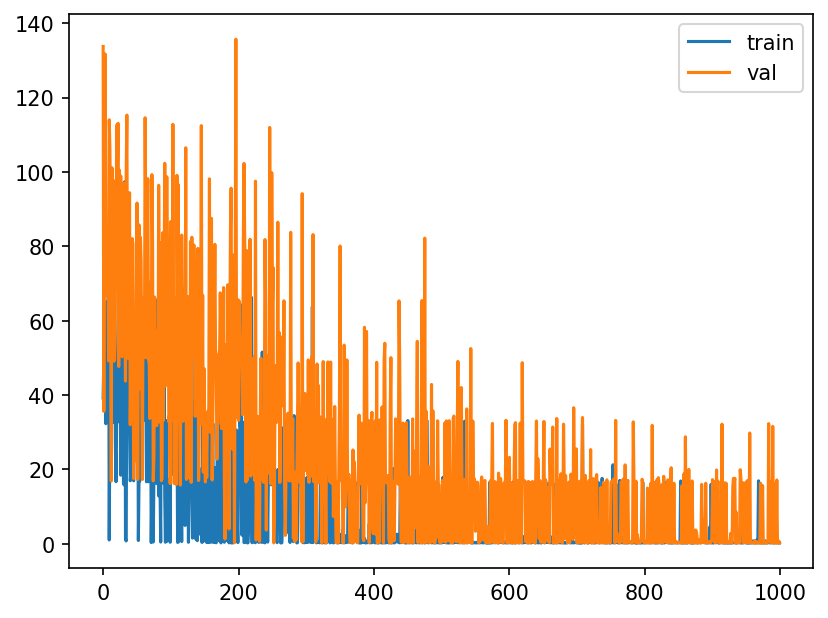

In [132]:
f, ax = plt.subplots()
ax.plot(loss_hist_train, label='train')
ax.plot(loss_hist, label='val')
ax.legend()

In [88]:
val_xs.shape

torch.Size([2, 50, 1])

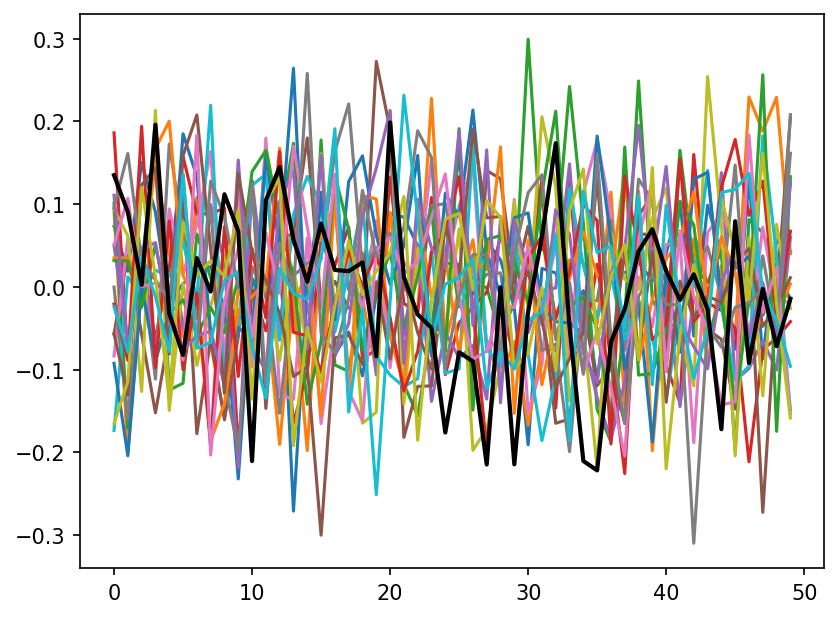

In [108]:
# Plot prediction
N = 20
j = 0
samples = flow(conditioner_rnn(val_xs[j:(j+1)])).sample((N,))
samples = torch.cat((torch.zeros((N,1,1)), samples))
# samples = torch.clip(samples, -1, 1)
reconstructions_x = run_autoregressive_model(samples, 
                                             n_timesteps=n_timesteps, 
                                             sigma_noise=sigma_noise).cpu().numpy()
for i in range(N):
    plt.plot(reconstructions_x[i,0,:,0])
plt.plot(val_xs[j,:,0], color = "black", linewidth=2)

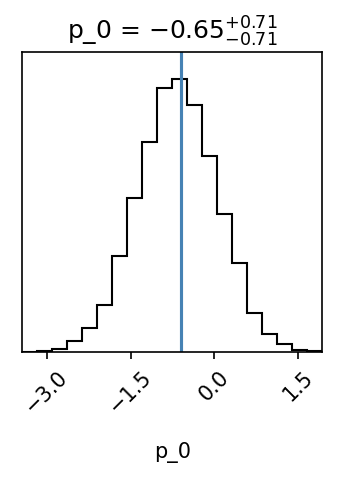

In [136]:
j = 2
# plot_flow_posterior(flow, conditioner_rnn(xs[j:j+1]), torch.tensor([0.1, -0.3, -0.6, 0.3])[j:j+1])
plot_flow_posterior(flow, summarise_ar1(xs[j:j+1]), torch.tensor([0.1, -0.3, -0.6, 0.3])[j:j+1])

tensor([-0.7539])


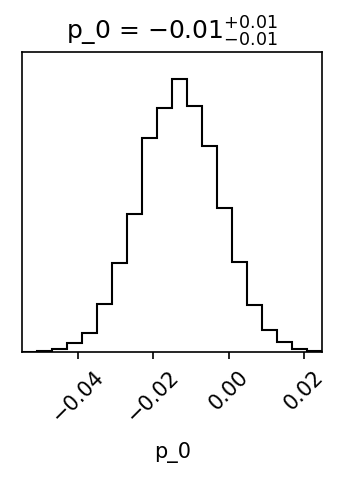

In [40]:
test_theta = sample_prior((1,))
print(test_theta)
test_x = run_autoregressive_model(test_theta.reshape(1,1,-1), n_timesteps=n_timesteps, sigma_noise=sigma_noise)
flow.load_state_dict(torch.load("./best_model.pth"))
plot_flow_posterior(flow, conditioner_rnn(test_x[0]), test_theta)
# plt.xlim(-2,2)

# Comparison with Pyro

In [116]:
mcmc = fit_autoregressive_model_pyro(xs[1], sigma_noise, num_samples=10000, warmup_steps=10000, n_parameters=2)

Sample: 100%|██████████████████████████████████████| 20000/20000 [18:56, 17.60it/s, step size=8.04e-01, acc. prob=0.913]                                                                                    


In [117]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
phi_1[0,0]      0.02      0.01      0.02     -0.00      0.04   7268.81      1.00
phi_2[0,0]     -0.23      0.44     -0.23     -0.87      0.51   8904.26      1.00

Number of divergences: 0


In [119]:
flow_samples = flow(conditioner_rnn(xs[1:2])).sample((10000,))
#flow_samples = clip_samples(flow_samples)

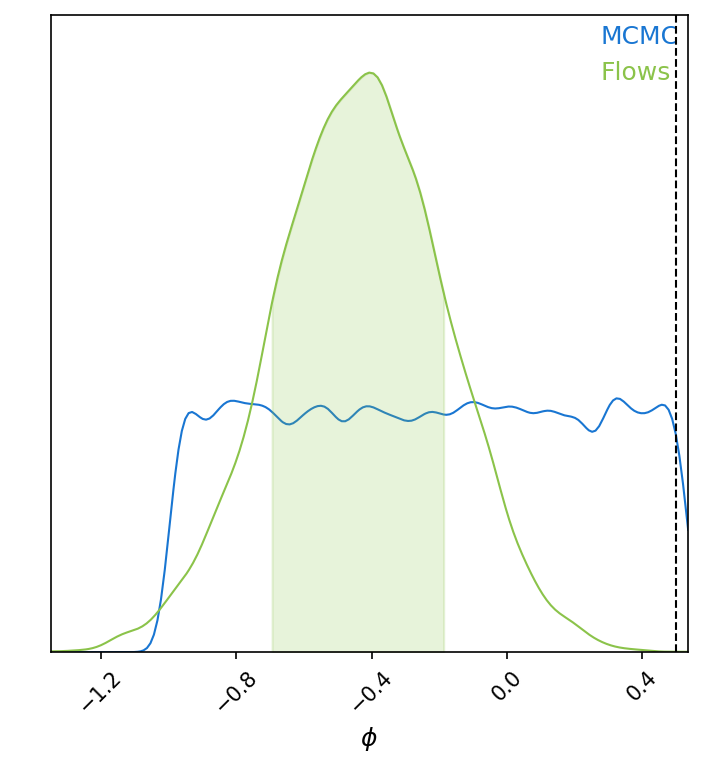

In [121]:
c = ChainConsumer()
c.add_chain(mcmc.get_samples()["phi_2"].numpy(), parameters = ["$\phi$"], name = "MCMC")
c.add_chain(flow_samples.flatten().numpy(), parameters = ["$\phi$"], name="Flows")
c.plotter.plot(truth=true_parameters.numpy(), figsize="column");

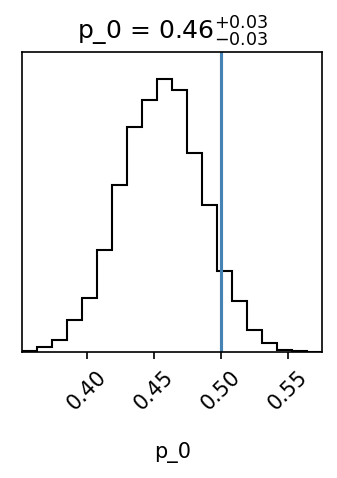

In [18]:
plot_flow_posterior(flow, conditioner_rnn(x_obs[0]), true_parameters)

In [137]:
import scipy.stats

In [144]:
def ar1_mh(x, init_theta, lower=-1, upper=1, n_samples=100_000, var=None, seed=None):
    
    """
    Assumes uniform prior
    """
    
    if not (seed is None):
        np.random.seed(seed)
    if var is None:
        var = 1.
    std = np.sqrt(var)
    curr_theta = init_theta
    curr_ll = -((x[1:] - curr_theta*x[:-1])**2).sum()/(2*var)
    iterator = tqdm(range(n_samples))
    acc_rate = 0.
    samples = []
    for t in iterator:
        prop_theta = curr_theta + std * np.random.randn()            
        if (prop_theta >= lower) and (prop_theta <= upper):
            forward = scipy.stats.norm.logpdf(prop_theta, loc=curr_theta, scale=std)
            backward = scipy.stats.norm.logpdf(curr_theta, loc=prop_theta, scale=std)
            new_ll = -((x[1:] - prop_theta*x[:-1])**2).sum()/(2*var)
            log_a = backward + new_ll - curr_ll - forward
            if np.log(np.random.random()) < log_a:
                # Accept 
                curr_theta = prop_theta
                curr_ll = new_ll
                acc_rate += 1.
        samples.append(curr_theta)
        iterator.set_postfix({"acc rate":acc_rate/(t+1)})
    return samples

In [145]:
samples = ar1_mh(xs[2], 0., var=0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:51<00:00, 894.44it/s, acc rate=0.77]


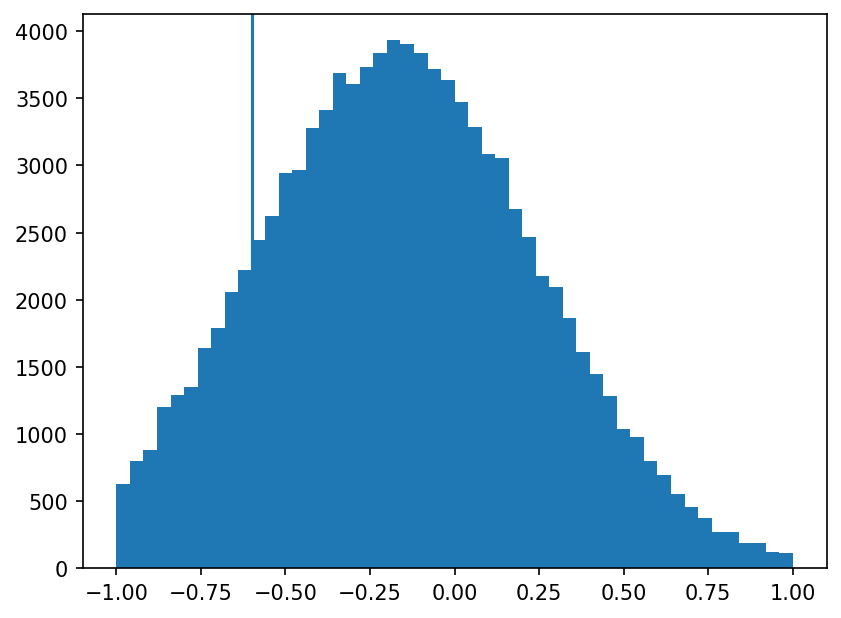

In [147]:
plt.hist(samples, bins=50)
plt.axvline(-0.6)